## Grad-CAM with pretrained model(AlexNet, VGGnet)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os 
import copy

from PIL import Image
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#parameters
image_size = 224
num_classes = 1000

### Model (Pre-trained models)

In [5]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


### AlexNet

In [6]:
#Pre-trained AlexNet from model_zoo
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        
        if maxpool==True:
            self.layer = nn.Sequential(
                        nn.Conv2d(3, in_ch, kernel_size, stride=stride, padding=padding),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2),
                        nn.Conv2d(in_ch, out_ch, kernel_size=5, stride=1, padding=padding),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=3, stride=2)
                
            )
        else:
            self.layer = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding),
                    nn.ReLU(inplace=True)
            )

        
    def forward(self, x):
        return self.layer(x)

    
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
                        AlexNet_Block(64, 192, 11, 4, 2, maxpool=True),
                        AlexNet_Block(192, 384, 3, 1, 1, maxpool=False),
                        AlexNet_Block(384, 256, 3, 1, 1, maxpool=False),
                        nn.Conv2d(256, 256, 3, stride=1, padding=1),
                        nn.ReLU(inplace = True),
                        nn.MaxPool2d(kernel_size=3, stride=2)
        )
        

        self.fc_layer = nn.Sequential(
                        nn.Dropout(),
                        nn.Linear(9216,4096),
                        nn.ReLU(inplace=True),
                        nn.Dropout(),
                        nn.Linear(4096,4096),
                        nn.ReLU(inplace=True),
                        nn.Linear(4096,num_classes)
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = self.features(x)    
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out

### VGGnet-16

In [25]:
#Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
                'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
                'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
                'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',}

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
 
class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        self.features = features
        
        self.fc_layer = nn.Sequential(
                nn.Linear(25088, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        out = self.features(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        
        return out
                
def make_layers(cfg, batch_norm=False):
    vgg16 = cfg[:]
    index = []
    for i in vgg16:
        if i == 'M':
            # To check index of maxpool layer
            index.append(vgg16.index(i))
            # remove 'M' so that can make conv layers easier 
            vgg16.remove(i)

    # Make conv layers
    layers = []
    for i in range(len(vgg16)):
        if i == 0:
            layers.append(nn.Conv2d(3, vgg16[i], 3, stride=1, padding=1))
        else:
            layers.append(nn.Conv2d(vgg16[i-1], vgg16[i], 3, stride=1, padding=1))


    # Insert relu function after conv layer
    layer2 = []
    for i in layers:
        layer2.append(i)
        if type(i) == torch.nn.modules.conv.Conv2d:
            layer2.append(nn.ReLU(inplace=True))

    # Insert maxpool layers to original position
    for i in index:
        if i != index[-1]:
            layer2.insert(2*i+index.index(i),nn.MaxPool2d(2,2))
        else:
            layer2.append(nn.MaxPool2d(2,2))
        
    sequential = nn.Sequential(*layer2)

    return sequential
            

#### Model instantiation(AlexNet and VGG-16)

In [26]:
print('STEP 4: INSTANTIATE MODEL CLASS')

##AlexNet
def alexnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_AlexNet['alexnet'])
    pretrained_key = list(pretrained_dict)
    new_state_dict = OrderedDict()
    model_dict = model.state_dict()
    if pretrained:
        for i, (key, value) in enumerate(model_dict.items()):
            # Get only feature's weight from model zoo(pretrained weight)
            if 'feature' or 'fc_layer' in key:
                new_state_dict[key] = pretrained_dict[pretrained_key[i]]
            else:
                new_state_dict[key] = value
                
        model.load_state_dict(new_state_dict)

    return model

model_AlexNet = alexnet(AlexNet(), pretrained=True)

## VGG-16, no batch_norm
def vggnet(model, pretrained=False):
    pretrained_dict = model_zoo.load_url(pretrained_vgg['vgg16']) 
    model_dict = model.state_dict()

    if pretrained:
        # Get only features's weight from model zoo(pretrained weight)
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        
    return model

model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


In [32]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))

print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
     AlexNet_Block-7          [-1, 192, 13, 13]               0
            Conv2d-8          [-1, 384, 13, 13]         663,936
              ReLU-9          [-1, 384, 13, 13]               0
    AlexNet_Block-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
    AlexNet_Block-13          [-1, 256, 13, 13]               0
           Conv2d-14

### Grad-CAM mask generating and visualizing with given test images

In [33]:
#test images with ImageNet class number
test_list = (('dataset/lab9/test_images/kingsnake.jpg', 56),
             ('dataset/lab9/test_images/cat_dog.png', 243),
             ('dataset/lab9/test_images/cat_dog.png',282),
             ('dataset/lab9/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake',243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

#### Grad-CAM generator class 

In [34]:
class GradCAM():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradient = None        
    
    # A backward hook function to save gradients(weights for visualizing)
    def save_gradient(self, grad): 
        self.gradient = grad
                
    def forward_model(self,x):
        out = self.model.features[:-2](x)
        out.register_hook(self.save_gradient)
        feature_maps = self.model.features[-2:](out)
        score = feature_maps.view(feature_maps.size(0),-1)
        score = self.model.fc_layer(score)
        
        return feature_maps, score
        
    def gen_CAM(self, img, one_hot_target):
        # Produce score of class and feature maps
        feature, output = self.forward_model(img)
        
        # Compute gradient of the score for class w.r.t feature maps of last conv layer
        self.model.zero_grad()
        output.backward(gradient = one_hot_target, retain_graph=True)
        gradients = self.gradient.data.cpu().numpy()[0]
        
        # Global averaging
        weights = np.mean(gradients, axis=(1, 2))
        
        # Generate grad-cam mask
        activation = feature.cpu().data.numpy()[0]
        cam = np.ones(activation.shape[1:])
        for i, w in enumerate(weights):
            cam += w * activation[i]
            
        # Resize
        cam = cv2.resize(cam, (img.size(2),img.size(3)))
        
        # ReLU to obtain a final mask
        cam = F.relu(torch.Tensor(cam)).cpu().data.numpy()
        
        # Min/Max Normalization
        cam = (cam-np.min(cam))/(np.max(cam) - np.min(cam) + 1e-08) 
        cam = np.uint8(cam * 255)
        
        return cam

In [35]:
# image array to image tensor
def preprocess_image(img, resize_img=True):
   
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1) 

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    return img_tensor

#image tensor to image array
def reprocess_image(img):
    
    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)
    
    return img_re

#### Grad_CAM Visulaization with given test images


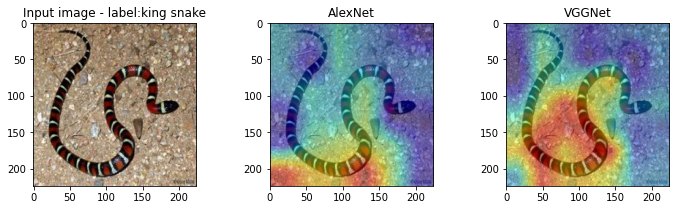

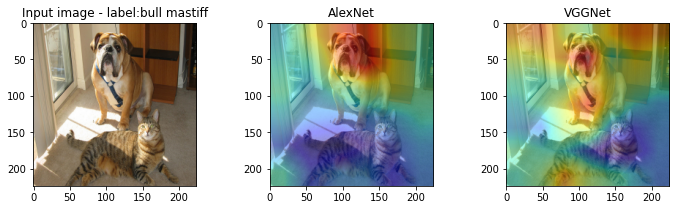

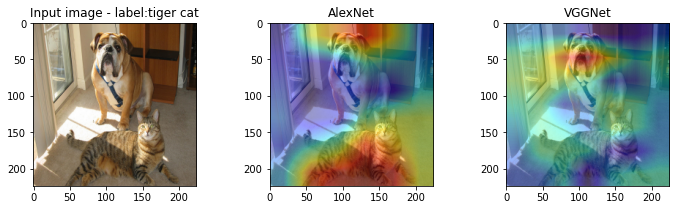

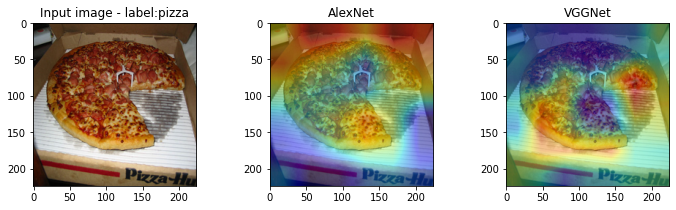

In [36]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)
    
    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)
    
    
    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

### *References*
[1] https://arxiv.org/pdf/1610.02391.pdf <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] https://bob3rdnewbie.tistory.com/320 <br>
[5] https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook <br>
[6] https://arxiv.org/pdf/1412.6806.pdf <br>
[7] https://arxiv.org/pdf/1311.2901.pdf <br>
[8] https://medium.com/@jamesvanneman/paper-club-visualizing-and-understanding-convolutional-networks-629fef9ceb8b <br>